# <u>Grupo 1: Demanda de biciletas en Seul</u>

## <u>Integrantes:</u>

* Llanes, Federico Nicolás
* Rodríguez Puertas, Miguel ignacio

## <u>Direcciones de correo electrónico:</u>

* fllanes@estudiantes.unsam.edu.ar
* mirodriguezpuertas@estudiantes.unsam.edu.ar


#### <u>Descripción:</u>

El dataset "Seoul Bike Sharing Demand", disponible en: <a href="https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand">https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand</a>, fue generado a partir de datos de puntos de retiro de bicicletas «docks» rentadas por los usuarios en la ciudad de Seúl, entre diciembre de 2017 y noviembre de 2018. Este sistema de préstamo es una propuesta de transporte alternativo en la ciudad a un costo accesible. El usuario toma la bicicleta en el punto de retiro más cercano donde se encuentre y la devuelve en el punto más próximo a su destino, similar al sistema de la Ciudad Autónoma de Buenos Aires.

El dataset incluye registros por hora del alquiler de bicicletas, junto con datos meteorológicos y detalles sobre días festivos y si funcionaba o no el sistema ese día. Cada día cuenta con 24 entradas (una por cada hora del día), abarcando un año completo de datos.


**<u>Target:</u>** Rented Bike count

**<u>Tipo de problema:</u>** Regresión

**<u>Pregunta/idea:</u>** Predecir, ¿en qué momentos del día y bajo qué condiciones la demanda de bicicletas es mayor?

**<u>Métricas:</u>**

* Coeficiente de determinación (R²) para medir qué tanto las condiciones climáticas y los momentos del día explican la variabilidad en la demanda de bicicletas. Un valor alto de R² indicará que el modelo explica una gran parte de la demanda de bicicletas, mientras que un valor bajo sugerirá que hay otros factores no considerados que están influyendo en la demanda.

* El error cuadrático medio (RMSE) nos permitirá evaluar el rendimiento del modelo al darnos una estimación del error promedio en la predicción  de la  demanda. En particular RMSE castiga más fuertemente los errores grandes, lo cual es importante en este caso para evitar sobrestimaciones considerables en la demanda de bicicletas. También es importante considerar que la demanda mínima solo puede llegar a cero.

## Análisis Exploratorio de Datos

In [2]:
# Cargamos las librerías necesarias para las diferentes secciones del trabajo

#Librerías de manejo de datos
import numpy as np
import pandas as pd

#Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

#Librerías de train/test y selección de modelos
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold


#Librerías de preprocesamiento y pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

#Librerías de estadística y modelos
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer

In [3]:
#Cargamos los datos y hacemos un head() para ver las primeras filas
data = pd.read_csv('dataset/SeoulBikeData.csv', sep=',',encoding='windows-1252')
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
#Vemos el tipo de datos de cada columna y la cantidad de entradas
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

Se observan 14 columnas con 8760 entradas, no tienen datos faltantes. Hay 3 columnas categóricas ("Seasons", "Holiday" y "Functioning Day"), una que es "Date" que fue convertida en String durante la lectura de los datos y las restantes todas continen valores numéricos.

In [5]:
# Creamos una copia de los datos para no modificar los originales
copia_data = data.copy()

In [6]:
# Renombramos las columnas para mayor claridad
columnas_renombradas = ['date', 'rented_bike_count', 'hour', 'temperature', 'humidity',
                'wind_speed', 'visibility', 'dew_point_temperature', 'solar_radiation',
                'rainfall', 'snowfall', 'seasons', 'holiday', 'functional_day']
copia_data.columns = columnas_renombradas

Realizamos en primer lugar un gráfico de frecuencia de la variable target para tener una noción de la distribución de la demanda de bicicletas, y luego a continuación un detalle de sus estadísticos descriptivos:

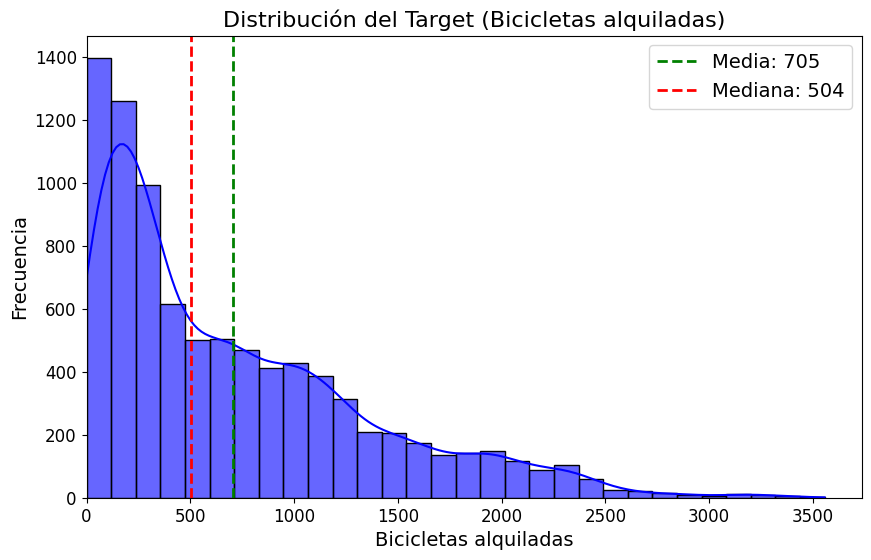

In [10]:
# Creamos el histograma con KDE (estimación de densidad de Kernel) para ver la distribución del target
# con alguna aproximación de su función de densidad
plt.figure(figsize=(10, 6))
sns.histplot(copia_data['rented_bike_count'], bins=30, color='blue', alpha=0.6, kde=True)

# Calculamos para marcar media y mediana
mean_ = np.mean(copia_data['rented_bike_count'])
median_ = np.median(copia_data['rented_bike_count'])
plt.axvline(mean_, color='green', linestyle='--', label=f'Media: {mean_:.0f}', linewidth=2)
plt.axvline(median_, color='red', linestyle='--', label=f'Mediana: {median_:.0f}', linewidth=2)

plt.xlim(0)

# Agregamos título y etiquetas
plt.title('Distribución del Target (Bicicletas alquiladas)', fontsize=16)
plt.xlabel('Bicicletas alquiladas', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot
plt.legend(fontsize=14)
# plt.savefig("distribucion_target.png", bbox_inches='tight', dpi=300)
plt.show()


In [11]:
# Vemos los estadísticos descriptivos del target
copia_data['rented_bike_count'].describe().astype(int)

count    8760
mean      704
std       644
min         0
25%       191
50%       504
75%      1065
max      3556
Name: rented_bike_count, dtype: int64

<u>Selección de Atributos para primera visualización:</u>

- Hour (Hora del día):
    - <u>Justificación:</u> La hora del día es crucial a la hora de analizar la demanda, porque el uso de bicicletas es probable que siga un patrón diario, con picos en las horas de inicio y fin de la jornada laboral. Además, la demanda podría ser más baja durante las horas de la madrugada.

- Temperature (°C):
    - <u>Justificación:</u> Se selecciona la temperatura como una de las variables iniciales de análisis. Se espera que temperaturas moderadas estén asociadas a una mayor demanda, mientras que temperaturas extremas podrían tener un efecto inverso, reduciéndola.

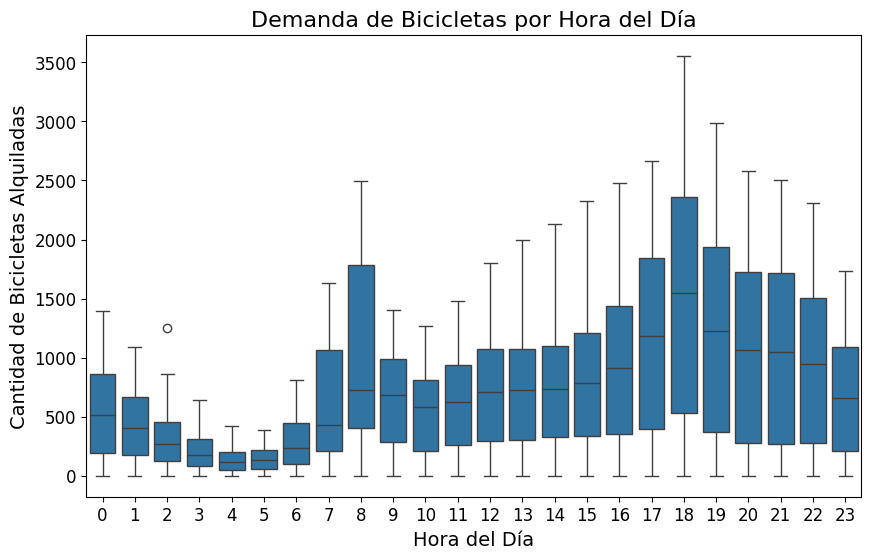

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Hour', y='Rented Bike Count', data=data)
plt.title('Demanda de Bicicletas por Hora del Día', fontsize=16)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Cantidad de Bicicletas Alquiladas', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("demanda_bicisxhora.png", bbox_inches='tight', dpi=300)
plt.show()

En este gráfico puede observarse un patrón claro de picos en la demanda de bicicletas. Durante las horas de la mañana (alrededor de las 8-9 am, coincidiendo con el horario laboral y estudiantil) se presenta un incremento notable en la demanda, así como otro pico significativo en la tarde, entre las 5 y las 7 pm.

Por otro lado, en las horas de la madrugada, la demanda es considerablemente baja, lo cual es esperado ya que la mayoría de las personas no se desplaza en bicicleta en esos horarios.

Este gráfico muestra la importancia de la variable "Hora del día" como un predictor relevante de la demanda de bicicletas. Se evidencia un patrón de uso diario que parecería estar directamente relacionado con el inicio y el fin de la jornada laboral. En un análisis posterior, estudiaremos si existe alguna relación entre el atributo 'Holiday' (indicador de feriado o día laboral) y las variables hora y demanda. Esto es, si el hecho de que sea feriado o día laboral influiría en la hora a la que se registra la demanda.

Por último, dato a resaltar, se ve cláramente un outlier a las 2AM, eso ocurrió el día 24/06/2018 con 1254 bicicletas. Buscamos si sucedió algo en particular que haya influenciado ese día. Hubo algunas celebraciones y elecciones locales, que tal vez pudieron influir en la demanda de bicicletas en ese día a esa hora, pero no obtuvimos nada concluyente, puede haber sido eso o simplemente una carga erronea del sistema.


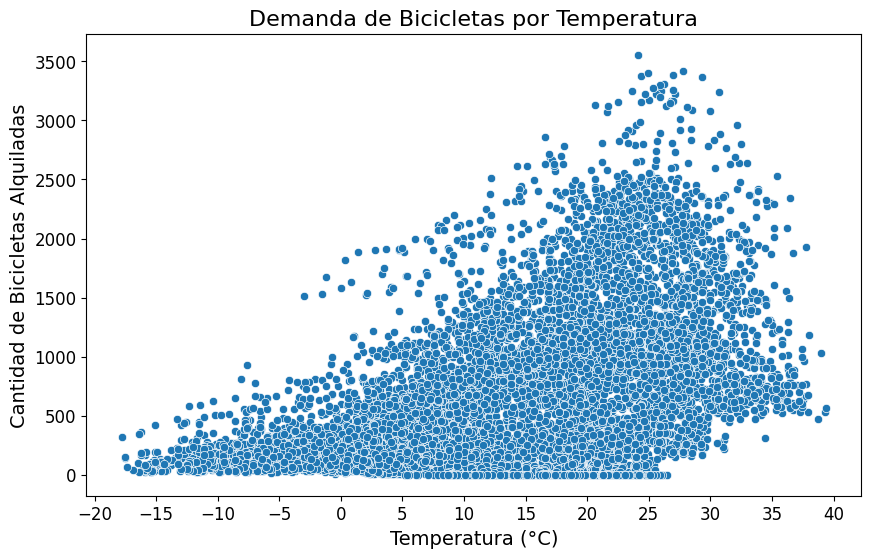

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature(°C)', y='Rented Bike Count', data=data)
plt.title('Demanda de Bicicletas por Temperatura', fontsize=16)
plt.xlabel('Temperatura (°C)', fontsize=14)
plt.ylabel('Cantidad de Bicicletas Alquiladas', fontsize=14)
min_temp = int(data['Temperature(°C)'].min()) // 5 * 5
max_temp = (int(data['Temperature(°C)'].max()) // 5 + 1) * 5
plt.xticks(ticks=range(min_temp, max_temp + 1, 5),fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("demanda_bicisxtemp.png", bbox_inches='tight', dpi=300)
plt.show()

En este gráfico se puede observar una tendencia positiva entre la temperatura y la cantidad de bicicletas alquiladas. A medida que la temperatura aumenta, también lo hace la demanda de bicicletas, pero entre los 25 y 35 grados se comienza a observar más dispersión en los datos (Se podría pensar que a temperaturas muy altas también es probable menos demanda). Sin embargo, es importante considerar que esta relación puede estar influenciada por otros factores no controlados en el análisis exploratorio de datos. Más adelante se realizará un análisis más profundo de la variable temperatura utilzándo un modelo de regresión con la variable expresada de forma polinómica, y veremos si mejora o no la predicción.

## Modelado y Evaluación

### **<u>Benchmark</u>**

Lo primero que debemos preguntarnos es: ¿cómo se comporta mi variable objetivo por sí misma, qué tipo de distribución tiene? Como vimos en el gráfico anterior, el target presenta una distribución sesgada positivamente, es decir, la cola de la distribución se extiende hacia la derecha. Esto nos indica que la mayoría de los valores de la demanda de bicicletas se encuentran en valores bajos, pero hay algunos valores muy altos que alargan la distribución hacia la derecha. A pesar de esto, podemos considerar como benchmark simple la media de la demanda de bicicletas, donde calculamos el RMSE en un modelo de demanda constante basado en la media y de esta forma obtenemos una base para modelos más complejos. Además, utilizaremos una división de los datos en 80% para entrenamiento y 20% para validación, lo que ayudará a verificar que el modelo generaliza bien y a evitar el sobreajuste.

El modelo de la media de la demanda de bicicletas es el siguiente:

$$
\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i
$$
Donde $\bar{y}$ es la media de la demanda de bicicletas, $n$ es la cantidad de observaciones y $y_i$ es la demanda de bicicletas en la observación $i$.

Cálculo del RMSE para el modelo de la media de la demanda de bicicletas:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y})^2}
$$

El $R^2$ para el modelo de la media de la demanda de bicicletas es 0, ya que la predicción es constante y no se ajusta a los datos. Se puede ver en la fórmula de $R^2$:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y})^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

Como $\hat{y}$ es la media de los datos y no ajusta ninguna variación, el numerador y el denominador de la fórmula del $R^2$ son iguales, resultando en $R^2 = 0$.

Sin embargo, a veces en validación, el $R^2$ puede ser cercano a 0, pero no exactamente 0 debido a las pequeñas diferencias numéricas y la variabilidad aleatoria en los datos.

In [14]:
# Generamos la división de los datos en entrenamiento y validación para el Benchmark
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(copia_data.drop(columns='rented_bike_count'),
                                                    copia_data['rented_bike_count'],
                                                    test_size=0.2,
                                                    random_state=42)

# Predicciones del modelo de la media usando solo los datos de entrenamiento
promedio_demanda = y_train_b.mean()
y_pred_mean = np.full(shape=len(y_test_b), fill_value=promedio_demanda)

# Cálculo del RMSE
rmse_del_promedio = root_mean_squared_error(y_test_b, y_pred_mean)

print(f"Promedio de la demanda en Entrenamiento: {promedio_demanda:.0f}")

print(f"RMSE del Promedio en Validación: {rmse_del_promedio:.0f}")

Promedio de la demanda en Entrenamiento: 705
RMSE del Promedio en Validación: 645


En en el resumen de los datos del target, podemos observar que la desviación estándar es de 644, mientras que el RMSE en validación es de 645. Esto podría indicar que el error promedio del modelo de la media al predecir la demanda es aproximadamente igual a la variabilidad natural de los datos. En otras palabras, el modelo de la media no captura mucha información útil sobre la estructura de la demanda y se limita a seguir el promedio global, sin lograr reducir significativamente el error respecto a la dispersión de los datos. Este RMSE del modelo de la media, aunque sencillo, no es una representación efectiva de la demanda, dado el sesgo y la alta variabilidad en los datos. Esta métrica puede usarse como benchmark, pero se esperaría que modelos más avanzados reduzcan el RMSE al captar patrones en los datos que el promedio no puede capturar.

Una vez fijamos nuestro benchmark, procedemos a realizar una matriz de correlación para ver cuáles atributos explican mejor nuestro target y cómo se correlacionan entre sí.

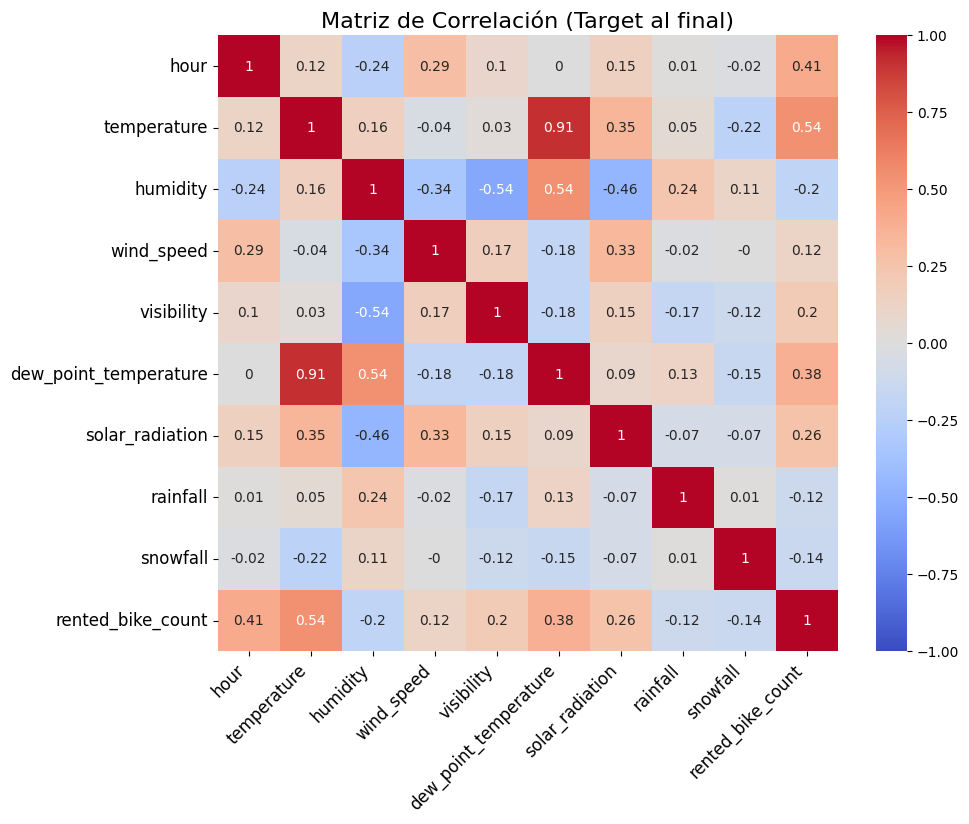

In [15]:
datos_numericos = copia_data.select_dtypes(include=[np.number])
matriz_de_correlacion = round(datos_numericos.corr(),2)

# Ordenar para que 'Rented Bike Count' (Nuestro Target) esté al final y sea más legible
orden_columnas = [col for col in matriz_de_correlacion.columns if col != 'rented_bike_count'] + ['rented_bike_count']
matriz_de_correlacion_reordenada = matriz_de_correlacion[orden_columnas].reindex(orden_columnas)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(matriz_de_correlacion_reordenada, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

ax.set_title("Matriz de Correlación (Target al final)", fontsize=16)

# plt.savefig("matriz_correlacion.png", bbox_inches='tight', dpi=300)

plt.show()

Seleccionamos dos atributos para un primer modelo sencillo: **hora** y **temperatura**. Los dos atributos que con esta matriz se puede observar son los más explicativos de la demanda de bicicletas y a su vez no se correlacionan entre sí de manera significativa.

A continuación, mostramos nuevamente un gráfico de la demanda de bicicletas por horas del día (ya visto con anterioridad). Este gráfico no solo nos permite observar el comportamiento de la demanda a lo largo del día, sino que además destaca otro aspecto a tener en cuenta: las horas 0h y 23h son horas de baja demanda, y al ser adyacentes, podrían provocar discontinuidades en la regresión lineal si no se transforman de forma trigonométrica. La transformación trigonométrica de la variable hora es necesaria para evitar cortes bruscos en modelos que requieren continuidad, como la regresión lineal.


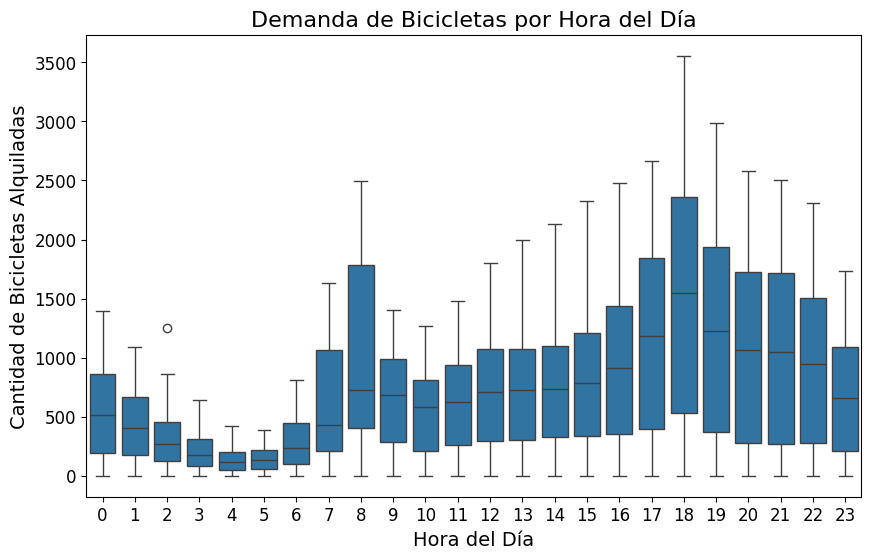

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Hour', y='Rented Bike Count', data=data)
plt.title('Demanda de Bicicletas por Hora del Día', fontsize=16)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Cantidad de Bicicletas Alquiladas', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [17]:
# Transformaciones trigonométricas para hour
copia_data['hour_sin'] = np.sin(2 * np.pi * copia_data['hour'] / 24)
copia_data['hour_cos'] = np.cos(2 * np.pi * copia_data['hour'] / 24)

In [18]:
# Eliminamos las columnas que no necesitamos
copia_data = copia_data.drop(columns=['date','hour'])

In [19]:
# Generamos la división de los datos en entrenamiento y validación para los modelos siguientes
X_train, X_test, y_train, y_test = train_test_split(copia_data.drop(columns='rented_bike_count'),
                                                    copia_data['rented_bike_count'],
                                                    test_size=0.2,
                                                    random_state=42)

### **<u>Primer Modelo</u>**

El modelo lineal de la regresión está dado por la siguiente fórmula:

$$
y = \beta_0 + \beta_1 \cdot \sin\left(\frac{2\pi \cdot \text{hour}}{24}\right) + \beta_2 \cdot \cos\left(\frac{2\pi \cdot \text{hour}}{24}\right) + \beta_3 \cdot \text{temperature}
$$

**<u>Aclaración importante:</u>** Estas dos variables no están correlacionadas entre sí (visto por la matriz de correlación), por lo que no se espera multicolinealidad en este primer modelo. Al realizar la regresión se utilizó StandardScaler para estandarizar a las variables, pero luego al momento de interpretar sus coeficientes, hay que realizar el paso inverso y desescalarlos.

**<u>Estandarización:</u>**
$$
X_{\text{escalado}} = \frac{X - \mu}{\sigma}
$$

**<u>Desescalado:</u>**
$$
X = X_{\text{escalado}} \cdot \sigma + \mu
$$


Además, podremos leer el coeficiente de la temperatura como el cambio en la demanda de bicicletas por cada grado (°C) de temperatura, y los coeficientes de la transformación trigonométrica a nivel global (no por hora).


In [20]:
# Seleccionamos las variables para nuestro modelo
X_train_r = X_train[['hour_sin', 'hour_cos', 'temperature']]
X_test_r = X_test[['hour_sin', 'hour_cos', 'temperature']]

# Escalamos las variables numéricas
preprocesador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train_r.columns)])

# Definimos el modelo de regresión lineal
modelo_lineal = LinearRegression()

# Creamos el pipeline
pipeline_lineal = Pipeline(steps=[('preprocesador', preprocesador), ('regresion_lineal', modelo_lineal)])

# Ajustamos el pipeline con el conjunto de entrenamiento
pipeline_lineal.fit(X_train_r, y_train)

# Obtenemos los coeficientes de la regresión lineal
coeficientes_lineales = pipeline_lineal.named_steps['regresion_lineal'].coef_
intercepto_lineal = pipeline_lineal.named_steps['regresion_lineal'].intercept_

# Predicciones para los conjuntos de entrenamiento y prueba
y_train_pred_linear = pipeline_lineal.predict(X_train_r)
y_test_pred_linear = pipeline_lineal.predict(X_test_r)

# Aplicamos clipping a las predicciones para que no haya valores menores a cero (MUY IMPORTANTE, el modelo no sabe de límites)
y_train_pred_linear = np.clip(y_train_pred_linear, 0, None)
y_test_pred_linear = np.clip(y_test_pred_linear, 0, None)

# Cálculo de RMSE y R2 para la regresión lineal
rmse_train_linear = root_mean_squared_error(y_train, y_train_pred_linear)
rmse_test_linear = root_mean_squared_error(y_test, y_test_pred_linear)
r2_train_linear = r2_score(y_train, y_train_pred_linear)
r2_test_linear = r2_score(y_test, y_test_pred_linear)

# Obtenemos el escalador utilizado en el preprocesamiento
scaler = pipeline_lineal.named_steps['preprocesador'].named_transformers_['num']

# Medias y desviaciones estándar utilizadas en el escalado
means = scaler.mean_
stds = scaler.scale_

coeficientes_desescalados = coeficientes_lineales / stds

# Desescalamos el intercepto
intercepto_desescalado = intercepto_lineal - sum((coeficientes_lineales * means) / stds)

# Creamos el DataFrame para los coeficientes escalados y desescalados
coeficientes_df = pd.DataFrame({
    'Variable': X_train_r.columns,
    'Coeficiente': coeficientes_lineales,
    'Coeficiente Desescalado': coeficientes_desescalados
})

# Añadimos el intercepto al DataFrame
coeficientes_df = pd.concat([
    coeficientes_df,
    pd.DataFrame({'Variable': ['Intercepto'], 
                'Coeficiente': [intercepto_lineal], 
                'Coeficiente Desescalado': [intercepto_desescalado]})
], ignore_index=True)


# Imprimimos los resultados formateados
print("Resultados de la Regresión Lineal")
print("="*40)
print(f"RMSE de Entrenamiento: {rmse_train_linear:.0f}")
print(f"RMSE de Validación: {rmse_test_linear:.0f}")
print(f"R\u00B2 de Entrenamiento: {r2_train_linear:.2f}")
print(f"R\u00B2 de Validación: {r2_test_linear:.2f}")
print("="*40)

print("Coeficientes de la Regresión Lineal:")
print(coeficientes_df.round(2).to_string(index=False))



Resultados de la Regresión Lineal
RMSE de Entrenamiento: 489
RMSE de Validación: 503
R² de Entrenamiento: 0.42
R² de Validación: 0.39
Coeficientes de la Regresión Lineal:
   Variable  Coeficiente  Coeficiente Desescalado
   hour_sin      -234.13                  -331.60
   hour_cos       -24.80                   -35.02
temperature       302.95                    25.48
 Intercepto       704.77                   374.75


**<u>Interpretación de los coeficientes a nuestra pregunta:</u>**


**<u>Momentos del día:</u>** La transformación trigonométrica aplicada a la hora del día mostró que la demanda de bicicletas sigue un comportamiento cíclico. El modelo sugiere que la demanda comienza a subir lentamente durante las primeras horas de la mañana y alcanza su pico en la tarde y  es más baja durante la madrugada y la noche, lo que es consistente con el uso cotidiano de bicicletas (mostrado en el gráfico de más arriba). A continuación se presenta una tabla en la que se describen los valores de seno y coseno en horas clave del día (valores que luego se multiplican con los coeficientes obtenidos en el modelo, **hour\_sin** (-331.60) y **hour\_cos** (-35.02):

| Hora | $$\sin\left(\frac{2\pi \cdot \text{hora}}{24}\right)$$ | $$\cos\left(\frac{2\pi \cdot \text{hora}}{24}\right)$$ |
|------|------------------------------------------------------|------------------------------------------------------|
| 0h    | 0                                                    | 1                                                    |
| 3h    | $\frac{\sqrt{2}}{2}$                                | $\frac{\sqrt{2}}{2}$                               |
| 6h    | 1                                                    | 0                                                    |
| 9h    | $\frac{\sqrt{2}}{2}$                                | $-\frac{\sqrt{2}}{2}$                                |
| 12h   | 0                                                    | -1                                                   |
| 15h   | $-\frac{\sqrt{2}}{2}$                               | $-\frac{\sqrt{2}}{2}$                                |
| 18h   | -1                                                   | 0                                                    |
| 21h   | $-\frac{\sqrt{2}}{2}$                               | $\frac{\sqrt{2}}{2}$                               |

**<u>Condiciones climáticas:</u>** El coeficiente positivo de la temperatura indica que a medida que la temperatura sube en un grado (C°), la demanda de bicicletas tiende a aumentar, lo cual refleja que en días más cálidos hay una mayor tendencia a usar bicicletas. Este resultado es coherente con lo que se esperaría, ya que las personas prefieren andar en bicicleta en condiciones climáticas más agradables.

El gráfico siguiente trata de demostrar de manera análoga lo explicado con la tabla, donde cada hora es reprentada dentro del intervalo $[0,2\pi]$

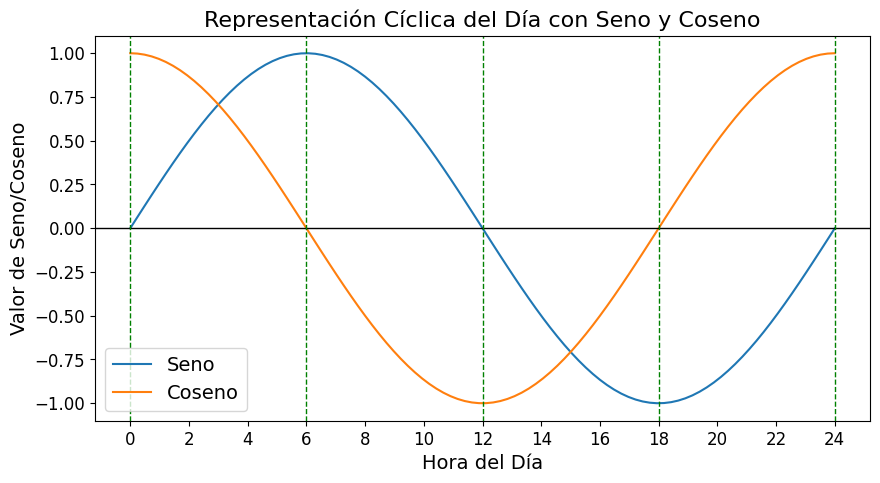

In [21]:
horas = np.linspace(0, 24, 100)
seno_horas = np.sin(2 * np.pi * horas / 24)
coseno_horas = np.cos(2 * np.pi * horas / 24)

plt.figure(figsize=(10, 5))
plt.plot(horas, seno_horas, label='Seno', linestyle='-')
plt.plot(horas, coseno_horas, label='Coseno', linestyle='-')
plt.axhline(0, color='black', linestyle='-', linewidth=1)

plt.title('Representación Cíclica del Día con Seno y Coseno', fontsize=16)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Valor de Seno/Coseno', fontsize=14)
plt.legend(fontsize=14)


plt.xticks(np.arange(0, 25, 2), fontsize=12)
plt.yticks(fontsize=12)

for hora in [0, 6, 12, 18, 24]:
    plt.axvline(hora, color='green', linestyle='--', linewidth=1)

# plt.savefig("dibujo_trig.png", bbox_inches='tight', dpi=300)

plt.show()


**<u>Interpretación de los coeficientes:</u>**

$$
\hat{y} = -331.60 \cdot \sin\left(\frac{2\pi \cdot \text{hour}}{24}\right) - 35.02 \cdot \cos\left(\frac{2\pi \cdot \text{hour}}{24}\right) + 25.48 \cdot \text{temperature}
$$

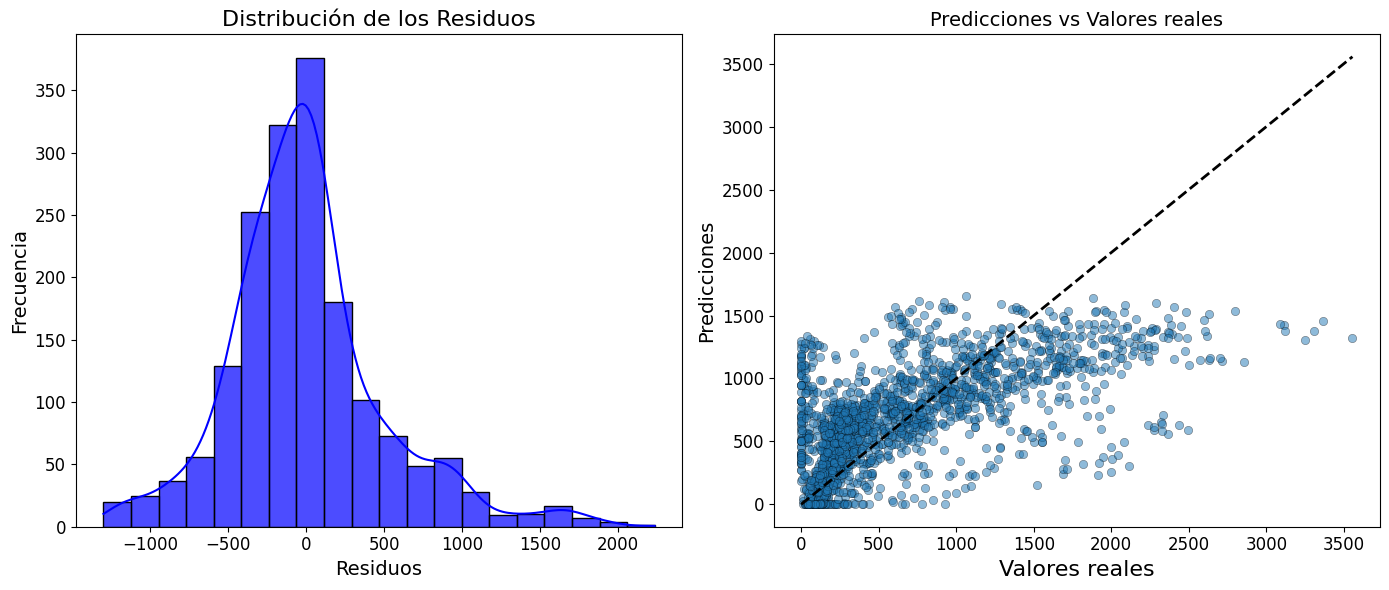

In [22]:
# Cálculo de los residuos
residuos_lineal = y_test - y_test_pred_linear

# Creamos una figura con dos subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de la distribución de los residuos
sns.histplot(residuos_lineal, bins=20, color='blue', alpha=0.7, kde=True, ax=ax[0])
ax[0].set_title('Distribución de los Residuos', fontsize=16)
ax[0].set_xlabel('Residuos', fontsize=14)
ax[0].set_ylabel('Frecuencia', fontsize=14)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)

# Gráfico de predicciones vs valores reales
ax[1].scatter(y_test, y_test_pred_linear, alpha=0.5, edgecolor='black', linewidth=0.4)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax[1].set_xlabel('Valores reales', fontsize=16)
ax[1].set_ylabel('Predicciones', fontsize=14)
ax[1].set_title('Predicciones vs Valores reales', fontsize=14)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

# plt.savefig("primer_modelo.png", bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

El gráfico de la distribución de los residuos parecería estar indicando una aproximación a la normalidad, aunque no de manera concluyente. Esto sugiere que el modelo está capturando parte de la tendencia de los datos, pero no completamente. Se puede observar una ligera cola hacia los residuos positivos, lo cual indica que el modelo tiende a subestimar la demanda de bicicletas en algunos casos.

El **RMSE** obtenido es de **503**, lo que significa que, en promedio, el modelo comete un error de 503 unidades en la predicción de la demanda de bicicletas.

Por otro lado, el $R^2$ de **0.39** indica que el modelo explica aproximadamente el 39% de la variabilidad en la demanda de bicicletas. Aunque no es un valor extremadamente alto, es un buen comienzo para un modelo simple con solo dos atributos (hora, transformada trigonométricamente, y temperatura). Sin embargo, se puede observar en el gráfico de predicciones vs valores reales que el modelo subestima la demanda en los casos de mayor demanda (idealmente deberían estar más cercanos a la línea de 45°)

### **<u>Segundo Modelo</u>**

Antes de proseguir con un modelo más complejo, se decidió realizar una transformación polinómica de la variable temperatura para ver si se logra mejorar la predicción. Como se se pudo observar en el segundo gráfico de la sección del Análisis exploratorio de datos, no era muy clara la relación entre la temperatura y la demanda de bicicletas, por la tanto, se analizaron diferentes grados de polinomios para ver si se logra mejorar la predicción. Finalmente, se optó por un polinomio de grado 3 en esta instancia luego de varias pruebas. Se probará en el modelo más simple y luego se probará en un modelo más complejo.

In [23]:
# Seleccionamos las variables para nuestro modelo
X_train_r = X_train[['hour_sin', 'hour_cos', 'temperature']]
X_test_r = X_test[['hour_sin', 'hour_cos', 'temperature']]

features_numericas = ['hour_sin', 'hour_cos']
feature_poly = ['temperature']

# Creamos transformaciones para variables numéricas, polinómicas y categóricas
preprocesador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('poly', Pipeline([('poly', PolynomialFeatures(degree=3, include_bias=False)),
                        ('scaler', StandardScaler())]), feature_poly)
    ])

# Definimos el modelo de regresión lineal
modelo_lineal = LinearRegression()

# Creamos el pipeline
pipeline_lineal = Pipeline(steps=[('preprocesador', preprocesador), ('regresion_lineal', modelo_lineal)])

# Ajustamos el pipeline con el conjunto de entrenamiento
pipeline_lineal.fit(X_train_r, y_train)

# Obtenemos los coeficientes de la regresión lineal
coeficientes_lineales = pipeline_lineal.named_steps['regresion_lineal'].coef_
intercepto_lineal = pipeline_lineal.named_steps['regresion_lineal'].intercept_

# Predicciones para los conjuntos de entrenamiento y prueba
y_train_pred_linear = pipeline_lineal.predict(X_train_r)
y_test_pred_linear = pipeline_lineal.predict(X_test_r)

# Aplicamos clipping a las predicciones para que no haya valores menores a cero (MUY IMPORTANTE, el modelo no sabe de límites)
y_train_pred_linear = np.clip(y_train_pred_linear, 0, None)
y_test_pred_linear = np.clip(y_test_pred_linear, 0, None)

# Cálculo de RMSE y R2 para la regresión lineal
rmse_train_linear = root_mean_squared_error(y_train, y_train_pred_linear)
rmse_test_linear = root_mean_squared_error(y_test, y_test_pred_linear)
r2_train_linear = r2_score(y_train, y_train_pred_linear)
r2_test_linear = r2_score(y_test, y_test_pred_linear)

## Obtener escaladores individuales
scaler_num = pipeline_lineal.named_steps['preprocesador'].named_transformers_['num']
scaler_poly = pipeline_lineal.named_steps['preprocesador'].named_transformers_['poly'].named_steps['scaler']

# Desescalado de coeficientes
means_num = scaler_num.mean_
stds_num = scaler_num.scale_
means_poly = scaler_poly.mean_
stds_poly = scaler_poly.scale_

# Dividimos los coeficientes en numéricos y polinómicos
coef_num = coeficientes_lineales[:len(features_numericas)]
coef_poly = coeficientes_lineales[len(features_numericas):]

# Desescalado de los coeficientes
coeficientes_num_desescalados = coef_num / stds_num
coeficientes_poly_desescalados = coef_poly / stds_poly

# Concatenar los coeficientes desescalados en un solo arreglo
coeficientes_desescalados = np.concatenate([coeficientes_num_desescalados, coeficientes_poly_desescalados])

# Desescalado del intercepto
intercepto_desescalado = intercepto_lineal - sum((coef_num * means_num) / stds_num) - sum((coef_poly * means_poly) / stds_poly)

# Obtenemos los nombres de las características después de la transformación para incluir los términos polinómicos
nombres_features = pipeline_lineal.named_steps['preprocesador'].get_feature_names_out()

# Creamos el DataFrame para los coeficientes escalados y desescalados
coeficientes_df2 = pd.DataFrame({
    'Variable': nombres_features,
    'Coeficiente': coeficientes_lineales,
    'Coeficiente Desescalado': coeficientes_desescalados
})

# Añadimos el intercepto al DataFrame
coeficientes_df2 = pd.concat([
    coeficientes_df2,
    pd.DataFrame({'Variable': ['Intercepto'],
                'Coeficiente': [intercepto_lineal],
                'Coeficiente Desescalado': [intercepto_desescalado]})
], ignore_index=True)


# Imprimir los resultados formateados
print("Resultados de la Regresión Lineal con Temperatura Polinómica")
print("="*40)
print(f"RMSE de Entrenamiento: {rmse_train_linear:.0f}")
print(f"RMSE de Validación: {rmse_test_linear:.0f}")
print(f"R\u00B2 de Entrenamiento: {r2_train_linear:.2f}")
print(f"R\u00B2 de Validación: {r2_test_linear:.2f}")
print("="*40)

print("Coeficientes de la Regresión Lineal:")
print(coeficientes_df2.round(2).to_string(index=False))

Resultados de la Regresión Lineal con Temperatura Polinómica
RMSE de Entrenamiento: 480
RMSE de Validación: 495
R² de Entrenamiento: 0.45
R² de Validación: 0.41
Coeficientes de la Regresión Lineal:
           Variable  Coeficiente  Coeficiente Desescalado
      num__hour_sin      -244.32                  -346.02
      num__hour_cos       -31.98                   -45.16
  poly__temperature       275.87                    23.20
poly__temperature^2       490.32                     1.54
poly__temperature^3      -485.88                    -0.05
         Intercepto       704.77                   276.98


**<u>Interpretación de los coeficientes a nuestra pregunta:</u>**


**<u>Momentos del día:</u>** Esto no varió respecto al primer modelo, ya que la transformación trigonométrica de la hora del día sigue siendo la misma. La demanda de bicicletas sigue un comportamiento cíclico, aumentando las primeras horas de la mañana y alcanzando su pico en la tarde, y una baja demanda durante la madrugada y la noche.

**<u>Condiciones climáticas:</u>** Los coeficientes de la temperatura nos indican que la relación con la demanda de bicicletas no es lineal. En un modelo lineal, cada grado de aumento en la temperatura implicaría un incremento constante en la demanda. Sin embargo, con el ajuste cúbico, observamos que en los extremos de la temperatura la demanda de bicicletas disminuye. Esto se debe al coeficiente negativo de la temperatura cúbica, el cual introduce una curvatura en la relación. A medida que la temperatura aumenta, también lo hace la demanda de bicicletas hasta un cierto punto, después del cual el efecto se invierte y la demanda comienza a caer. Por lo tanto, la relación entre la temperatura y la demanda de bicicletas no es lineal, sino que tiene un comportamiento más complejo. (Cobrando más sentido el gráfico mostrado en el análisis exploratorio de datos).

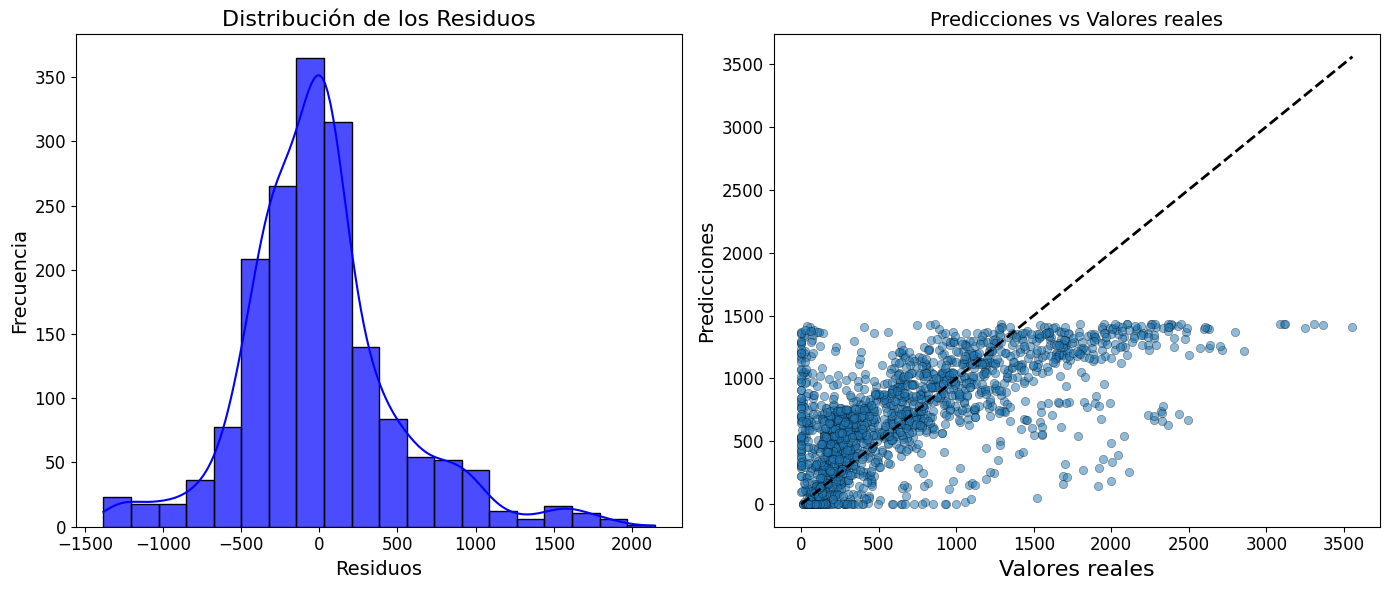

In [24]:
# Cálculo de los residuos
residuos_lineal = y_test - y_test_pred_linear

# Creamos una figura con dos subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de la distribución de los residuos
sns.histplot(residuos_lineal, bins=20, color='blue', alpha=0.7, kde=True, ax=ax[0])
ax[0].set_title('Distribución de los Residuos', fontsize=16)
ax[0].set_xlabel('Residuos', fontsize=14)
ax[0].set_ylabel('Frecuencia', fontsize=14)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)

# Gráfico de predicciones vs valores reales
ax[1].scatter(y_test, y_test_pred_linear, alpha=0.5, edgecolor='black', linewidth=0.4)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax[1].set_xlabel('Valores reales', fontsize=16)
ax[1].set_ylabel('Predicciones', fontsize=14)
ax[1].set_title('Predicciones vs Valores reales', fontsize=14)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

# plt.savefig("segundo_modelo.png", bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

Debido a que el modelo anterior, tanto el lineal simple con la temperatura ajustada polinómicamente como el que no la ajusta (sus gráficos difieren sutilmente), no lograron capturar de manera óptima la demanda de bicicletas, más aún difieren poco en las métricas (**pero cobra importancia la temperatura**), y tras utilizar diferentes técnicas para identificar los mejores atributos, observamos que las variables presentan un comportamiento bastante difícil de capturar. Por lo tanto primero se decidió realizar una técnica llamada VIF (Variance Inflation Factor) para ver si había mucha multicolinealidad entre las variables y si era necesario eliminar alguna. El VIF mide cuánto aumenta la varianza de un coeficiente de regresión debido a la multicolinealidad. Si el VIF es mayor a 10, se considera que hay multicolinealidad.

In [25]:
# Incluimos todas las feautures numéricas
features_numericas = ['hour_sin', 'hour_cos', 'temperature',
                    'humidity', 'wind_speed', 'visibility',
                    'dew_point_temperature', 'solar_radiation',
                    'rainfall', 'snowfall']

df_numerico = copia_data[features_numericas]

# Función para calcular el VIF
def calcular_vif(data, features):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(data[features].values, i) for i in range(len(features))]
    return vif_data

# Calculamos el VIF solo para las variables numéricas
vif_resultados_numericos = calcular_vif(df_numerico, features_numericas)

print(vif_resultados_numericos.round(2))

                Variable    VIF
0               hour_sin   1.43
1               hour_cos   2.22
2            temperature  31.32
3               humidity   6.10
4             wind_speed   5.09
5             visibility   9.32
6  dew_point_temperature  15.68
7        solar_radiation   4.88
8               rainfall   1.10
9               snowfall   1.13


Repetimos eliminando "dew_point_temperature"

In [26]:
# Incluimos todas las feautures numéricas
features_numericas = ['hour_sin', 'hour_cos', 'temperature',
                    'humidity', 'wind_speed', 'visibility',
                    'solar_radiation',
                    'rainfall', 'snowfall']

df_numerico = copia_data[features_numericas]

# Función para calcular el VIF
def calcular_vif(data, features):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(data[features].values, i) for i in range(len(features))]
    return vif_data

# Calculamos el VIF solo para las variables numéricas
vif_resultados_numericos = calcular_vif(df_numerico, features_numericas)

print(vif_resultados_numericos.round(2))

          Variable   VIF
0         hour_sin  1.39
1         hour_cos  2.21
2      temperature  3.51
3         humidity  5.94
4       wind_speed  4.81
5       visibility  4.59
6  solar_radiation  4.10
7         rainfall  1.09
8         snowfall  1.13


Se pudo observar que había multicolinealidad entre tempereture y dew_point_temperature era muy alta, por lo tanto se procedió a eliminar esta última. Otras características como la temperatura y la humedad capturan la mayor parte de la información de dew_point_temperature, por lo que eliminarla reduce la multicolinealidad y mejora la selección de variables al evitar redundancia de información.

### **<u>Tercer Modelo</u>**

Luego de todos estos ajustes, se decidió utilizar un **modelo de regresión lineal regularizado con Lasso**, ya que este modelo penaliza cada atributo adicional, ayudando en la selección de variables y en la armonización de aquellas que no son eliminadas. También aplicamos como en el caso anterior StandardScaler() y además usamos OneHotEncoding para las variables categóricas para hacerlas variables dummies (utilizando drop="First" para evitar colinealidad).

El modelo se implementó utilizando GridSearchCV para hallar el mejor $\lambda$, se utilizó vaidación cruzada con 5 folds en el 70% de entrenamiento y luego se verificó con el 30% de validación.

$$
y = \beta_0 + \sum_{i=1}^{8} \beta_i \cdot X_i + \sum_{n=1}^{3} \beta_{temp^n} \cdot \text{temperature}^n + \sum_{j=1}^{3} \gamma_j \cdot Z_j + \lambda \sum_{k=1}^{p} |\beta_k|
$$

Donde:

* $ y = \text{Demanda de bicicletas} $
* $ X_i = \text{Variables numéricas (hour\_sin, hour\_cos, etc.)} $
* $ Z_j = \text{Variables categóricas transformadas en dummies (seasons, holiday, functional\_day)} $
* $ p = \text{Número total de coeficientes de las variables numéricas y categóricas} $
* $ \lambda = \text{Parámetro de regularización} $


In [27]:
# Definimos las características numéricas y polinómicas
features_numericas = ['hour_sin', 'hour_cos', 'humidity', 'wind_speed', 'visibility',
                    'solar_radiation', 'rainfall', 'snowfall']
feature_poly = ['temperature']
features_categoricas = ['seasons', 'holiday', 'functional_day']

# Creamos transformaciones para variables numéricas, polinómicas y categóricas
preprocesador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('poly', Pipeline([('poly', PolynomialFeatures(degree=3, include_bias=False)),
                        ('scaler', StandardScaler())]), feature_poly),
        ('cat', OneHotEncoder(drop='first'), features_categoricas)
    ])

# Definimos el modelo Lasso sin alpha para que GridSearch lo ajuste
lasso = Lasso(max_iter=10000)
cv = KFold(n_splits=5, shuffle=True, random_state=29)

# Creamos el pipeline para Lasso
pipe_lasso = Pipeline(steps=[('preprocesador', preprocesador), ('lasso', lasso)])

# Configuración de GridSearchCV para optimizar alpha
param_grid = {'lasso__alpha': np.logspace(-4, 4, 100)}
grid_search = GridSearchCV(pipe_lasso, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Mejor alpha y modelo entrenado
mejor_alpha = grid_search.best_params_['lasso__alpha']
mejor_modelo = grid_search.best_estimator_

# Validación cruzada con el mejor modelo
rmse_scores = cross_val_score(mejor_modelo, X_train, y_train, cv=cv, scoring=make_scorer(root_mean_squared_error))
r2_scores = cross_val_score(mejor_modelo, X_train, y_train, cv=cv, scoring='r2')
mean_cv_rmse = rmse_scores.mean()
std_cv_rmse = rmse_scores.std()
mean_cv_r2 = r2_scores.mean()
std_cv_r2 = r2_scores.std()

# Métricas en el conjunto de prueba
y_test_pred = np.clip(mejor_modelo.predict(X_test), 0, None)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Resultados de métricas
print("Resultados de la Regresión Lasso con GridSearch y Temperatura Polinómica")
print("="*40)
print(f"RMSE promedio en validación cruzada: {mean_cv_rmse:.0f} ± {std_cv_rmse:.0f}")
print(f"R\u00B2 promedio en validación cruzada: {mean_cv_r2:.2f} ± {std_cv_r2:.2f}")
print(f"RMSE en validación: {test_rmse:.0f}")
print(f"R\u00B2 en validación: {test_r2:.2f}")
print(f"Mejor Alpha (\u03BB): {mejor_alpha:.4f}")
print("="*40)


# Obtenemos los coeficientes y nombres de las características transformadas
lasso_coefs = mejor_modelo.named_steps['lasso'].coef_
features_transformadas = mejor_modelo.named_steps['preprocesador'].get_feature_names_out()
coeficientes_lasso = pd.DataFrame({'Variable': features_transformadas, 'Coeficiente': lasso_coefs})

# Filtramos las variables con coeficientes distintos de cero y ajustamos nombres
coeficientes_no_nulos = coeficientes_lasso[coeficientes_lasso['Coeficiente'] != 0].reset_index(drop=True)
coeficientes_no_nulos['Variable'] = coeficientes_no_nulos['Variable'].str.replace('num__', '')
coeficientes_no_nulos['Variable'] = coeficientes_no_nulos['Variable'].str.replace('poly__', '')
coeficientes_no_nulos['Variable'] = coeficientes_no_nulos['Variable'].str.replace('cat__', '')

# Desescalado de coeficientes de variables numéricas y polinómicas
scaler_num = mejor_modelo.named_steps['preprocesador'].named_transformers_['num']
scaler_poly = mejor_modelo.named_steps['preprocesador'].named_transformers_['poly'].named_steps['scaler']
means_num = scaler_num.mean_
stds_num = scaler_num.scale_
means_poly = scaler_poly.mean_
stds_poly = scaler_poly.scale_

# Desescalado de coeficientes
coeficientes_numericos = coeficientes_no_nulos[coeficientes_no_nulos['Variable'].isin(features_numericas)]['Coeficiente'].values
coeficientes_numericos_desescalados = coeficientes_numericos / stds_num

coeficientes_polinomicos = coeficientes_no_nulos[coeficientes_no_nulos['Variable'].str.contains('temperature')]['Coeficiente'].values
coeficientes_polinomicos_desescalados = np.concatenate([
    coeficientes_polinomicos[:len(stds_poly)] / stds_poly,
    coeficientes_polinomicos[len(stds_poly):]
])

# Añadimos los coeficientes desescalados al DataFrame
coeficientes_no_nulos.loc[coeficientes_no_nulos['Variable'].isin(features_numericas), 'Coeficiente Desescalado'] = coeficientes_numericos_desescalados
coeficientes_no_nulos.loc[coeficientes_no_nulos['Variable'].str.contains('temperature'), 'Coeficiente Desescalado'] = coeficientes_polinomicos_desescalados

# Intercepto desescalado
lasso_intercept = mejor_modelo.named_steps['lasso'].intercept_
num_coef = min(len(coeficientes_polinomicos), len(means_poly), len(stds_poly))
intercepto_desescalado = lasso_intercept - np.sum((coeficientes_numericos * means_num) / stds_num) - np.sum((coeficientes_polinomicos[:num_coef] * means_poly[:num_coef]) / stds_poly[:num_coef])

# Imprimir los coeficientes en formato tabular
print("Coeficientes Lasso:")
print(coeficientes_no_nulos.round(2).to_string(index=False))
print(f"\nIntercepto Lasso (Escalado): {lasso_intercept:.2f}")
print(f"Intercepto Lasso (Desescalado): {intercepto_desescalado:.2f}")

Resultados de la Regresión Lasso con GridSearch y Temperatura Polinómica
RMSE promedio en validación cruzada: 420 ± 7
R² promedio en validación cruzada: 0.58 ± 0.01
RMSE en validación: 424
R² en validación: 0.57
Mejor Alpha (λ): 0.0320
Coeficientes Lasso:
          Variable  Coeficiente  Coeficiente Desescalado
          hour_sin      -222.40                  -314.98
          hour_cos       -64.60                   -91.23
          humidity      -146.21                    -7.15
        wind_speed       -10.44                   -10.08
        visibility         5.08                     0.01
   solar_radiation       -98.97                  -113.28
          rainfall       -80.65                   -75.58
          snowfall        12.98                    28.75
       temperature       271.95                    22.87
     temperature^2       500.04                     1.58
     temperature^3      -509.53                    -0.05
    seasons_Spring      -128.29                      NaN
   

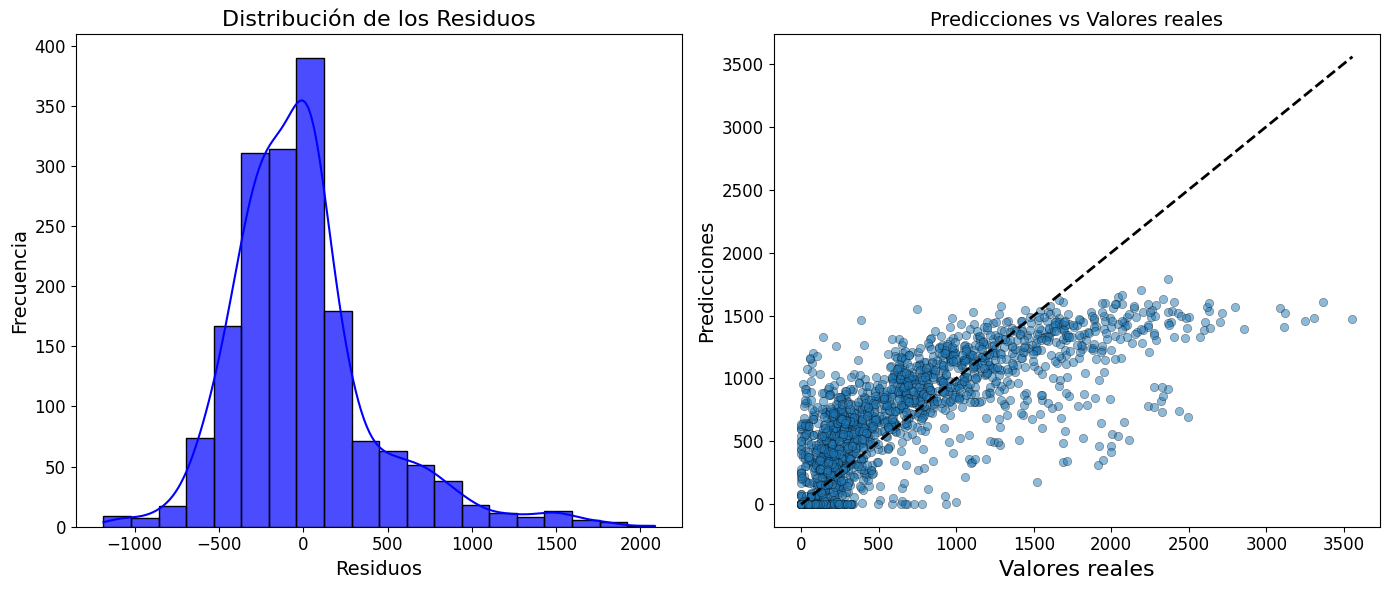

In [28]:
# Cálculo de los residuos
residuos_lasso = y_test - y_test_pred

# Creamos una figura con dos subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de la distribución de los residuos
sns.histplot(residuos_lasso, bins=20, color='blue', alpha=0.7, kde=True, ax=ax[0])
ax[0].set_title('Distribución de los Residuos', fontsize=16)
ax[0].set_xlabel('Residuos', fontsize=14)
ax[0].set_ylabel('Frecuencia', fontsize=14)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)

# Gráfico de predicciones vs valores reales
ax[1].scatter(y_test, y_test_pred, alpha=0.5, edgecolor='black', linewidth=0.4)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax[1].set_xlabel('Valores reales', fontsize=16)
ax[1].set_ylabel('Predicciones', fontsize=14)
ax[1].set_title('Predicciones vs Valores reales', fontsize=14)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

# plt.savefig("tercer_modelo.png", bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

En los gráficos se puede observar que los residuos de las predicciones tienden a ajustarse a una distribución normal, no obstante aun persiste una leve cola hacia la derecha, aunque menos pronuciada que en el modelo 1. Esto sugiere que la inclusión de más variables permitió disminuir la subestimación de la demanda de bicicletas en algunos casos.


El $R^2$ obtenido es de **0.57**, lo que indica un aumento en la capacidad explicativa del modelo respecto del anterior. Por otro lado, se obtuvo un valor de RMSE más bajo, esto nos indica que el modelo mejoró su capidad predictiva respecto del modelo anterior, obteniendo un RMSE de **424**.

Por otro lado, el gráfico de predicciones vs valores reales sigue mostrando una tendencia a subestimación en valores altos de demanda, aunque en menor medida que en el modelo anterior. Se puede observar que las predicciones tienden a estar más cerca de la línea de 45°, lo cual indica que el modelo está mejorando su capacidad predictiva.


**<u>Aclaraciones importantes para poder interpretar los coeficientes del modelo:</u>**

* Se deben estandarizar las variables (Esto se realiza por cuestión de linealización, para que no haya problemas de convergencia) y luego para poder interpretarlos es necesario desescalar los mismos. Además, las variables categóricas deben ser transformadas en variables dummies para poder ser usadas como predictores en el modelo.

* Aunque Lasso es útil para la selección de variables, su uso debe ser precavido. Por lo cual, a la hora de interpretar los coeficientes uno debe ser cuidadoso y usar otras técnicas como por ejemplo el VIF para ver si hay multicolinealidad entre las variables, ya que Lasso no siempre elimina variables altamente correlacionadas. En nuestro caso particular, la multicolinealidad detectada entre **temperature** y **dew_point_temperature** llevó a la eliminación de esta última, pero la temperatura se mantuvo en el modelo y fue ajustada de forma cúbica, lo que permite capturar posibles no linealidades en su relación con la demanda de bicicletas.

* En el caso de Lasso, los coeficientes que son reducidos a casi cero son los que no aportan casi información al modelo, por lo cual no se podrían considerar importantes, caso opuesto si son muy grandes (siempre en términos de valor absoluto). De todas maneras, hay que recordar que los coeficientes se leen de forma condicional, es decir, que muchas veces un coeficiente que no es significativo por sí solo, puede serlo si se lo compara con otro coeficiente.


**<u>Por otro lado, respondiendo a nuestra pregunta:</u>**

* La hora sigue jugando un rol similar en el modelo de Lasso polinómico, aunque con un poco más de relevancia el coseno de la hora.
* En este modelo se incluyeron variables dummies que parece que tienen bastante peso en la demanda de bicicletas, por lo cual sería interesante analizarlas con gráficos con respecto al target en futuros análisis.
* La radiación solar medida en (MJ/m²) es la segunda variable numérica más importante del modelo, seguida por la lluvia en (mm).
* Los coeficientes de la temperatura nos indican que la relación con la demanda de bicicletas no es lineal. Manteniéndose la tendencia (la curvatura cúbica) vista en el modelo anterior con coeficientes similares, pero con una mayor capacidad explicativa general del modelo.

### **<u>Análisis de los resultados (Comparativos)</u>**

Tras haber implementado tres modelos —una regresión lineal múltiple, una regresión lineal múltiple con ajuste polinómico y una regresión múltiple con ajuste polinómico y penalización de Lasso— además de un benchmark basado en la media histórica de la cantidad de bicicletas rentadas, hemos decidido optar por el modelo de Lasso por las siguientes razones:

* **Mejor RMSE:** El modelo de Lasso obtuvo un RMSE de 424 bicicletas, superando los 503 y 495 bicicletas de las regresiones lineales y los 645 del benchmark. Esto nos indica que la regresión Lasso tiene la mejor capacidad predictiva.

* **Mayor coeficiente de determinación (R^2):** El modelo de Lasso indicó que explicaba un 57% de la variabilidad de los datos respecto de un 39% y 41% de las regresiones lineales respectivamente y un 0% del benchmark, este último debido a que es la media de los datos y no ajusta ninguna variación.

* La distribución de los residuos de la regresión Lasso es la más cercana a una distribución normal.

* Las mejoras logradas se deben, en parte, a la incorporación de nuevas variables predictoras que desempeñaron un papel significativo en la optimización de las métricas y los residuos de la regresión Lasso. Entre estas variables, destacan **functional_day_Yes**, **rainfall**, **solar_radiation** y las estaciones del año, siendo especialmente relevante **seasons_Winter**. Además de haber evitado el factor de multicolinealidad entre **temperature** y **dew_point_temperature** usando VIF.


Los tres modelos lineales enfrentan dificultades para capturar las tendencias generales del problema, especialmente en lo que respecta a los valores extremos de la demanda de bicicletas. Hasta ahora, la regresión Lasso ha demostrado ser el mejor modelo para ajustar los datos, aunque su coeficiente de determinación sugiere que aún hay margen de mejora en la explicación de la variabilidad observada. El RMSE, el más bajo entre los modelos comparados, indica un avance significativo hacia la reducción de la distancia entre los valores reales y los predichos.

Sin embargo, como se mencionó anteriormente, Lasso presenta ciertas limitaciones que deben considerarse. A pesar de ello, sigue siendo un modelo bastante efectivo en la categoría de modelos lineales, lo que resalta la utilidad de este enfoque, especialmente al lidiar con la necesidad de regularización para selección de variables obtener un modelo con coeficientes no tan extremos. A medida que avanzamos, será esencial explorar técnicas adicionales que puedan abordar estas limitaciones (de mejores formas) y mejorar nuestras predicciones, tema que se discutirá en el próximo apartado.

### **<u>Conclusiones finales y pasos posible a seguir</u>**

Nuestro siguiente paso para mejorar los resultados del modelo sería explorar otros enfoques que puedan capturar mejor la naturaleza de los datos. Los modelos utilizados en este trabajo, como la regresión lineal y Lasso, asumen una relación lineal entre las variables predictoras y la demanda de bicicletas (con la excepción de la temperatura ajustada polinómicamente), pero además asumen que tienen una dispersión constante de los residuos. Sin embargo, los gráficos de residuos y las métricas sugieren que estos modelos no logran capturar completamente las variaciones en la demanda, especialmente en los valores más altos.

**<u>Hay dos caminos posibles:</u>**

* Modelos de GLM de conteo: Dado que la demanda de bicicletas es un valor discreto (un valor de conteo), se podría probar con Modelos Lineales Generalizados. Los modelos de Poisson o Binomial Negativa son particularmente útiles para datos de conteo, ya que pueden manejar la variabilidad (sobredispersión) de manera más efectiva que los modelos lineales tradicionales.
  
  * Modelo de Poisson: Este modelo es adecuado cuando el número de eventos (en este caso, alquiler de bicicletas) sigue una distribución de Poisson y la varianza es igual a la media. Si bien puede ser un buen punto de partida, es importante verificar si hay sobredispersión (cuando la varianza es mayor que la media).
  
  * Modelo de Binomial Negativa: Este modelo extiende el modelo de Poisson al permitir una varianza mayor que la media (sobredispersión), lo que podría ser más adecuado si observamos que la demanda de bicicletas muestra más variabilidad de lo que el modelo de Poisson puede manejar.


Es importante tener en cuenta con los GLM que aparecen otras métricas de evaluación, no sólo las planteadas en el trabajo. Por ejemplo, la devianza, que es una medida de bondad de ajuste para los modelos de GLM.


* Modelos de Ensambles: Otra dirección interesante y más acorde a lo visto en esta materia sería probar con modelos de ensambles, como Random Forest o XGBoost, que pueden capturar relaciones más complejas y no lineales entre las variables. Tienden a ser robustos frente a relaciones no lineales y podrían mejorar significativamente el rendimiento en la predicción de la demanda, especialmente cuando se tienen muchas variables relevantes que interactúan de manera compleja.

